# Getting Started Replaying Old Data

- Work under a separate branch with git (i.e. git checkout -b my-new-branch)

- Copy this ipynb file to a folder within your Projects folder - better not work within this (Projects_Templates/2_ReplayOldDataAsNF) folder. Come up with a nice name for the new folder.

- Then enter your new folder within Projects (maybe 3_New_Assignment_Fancy_Analysis), and use the code in here for for your purposes as you see fit

- you might wish to grab some data from Leipzig here: ldrive, under **Lab_MichaelB/Johan/nf/rawdata/ReplayDataTest**


- the main gist of re-playing existing data is:
    - that your first load everything into a big matrix with mne
    - then initialize a specific **amp** (i.e., the "replayamp")
    - then do exactly the same as normal, with a while True loop with calls to amp.get_data()
    
- you may wish to put all of the import statements at the top

- if you get a module not found error, add the mushu folder to the python path. A good analogy is the matlab's 'addpath' utility.


For example:
```python
sys.path.append('/home/nfcontrol/nf/nf-rtime/mushu/')      # this is to talk with the amplifer
sys.path.append('/home/nfcontrol/nf/nf-rtime/wyrm/') 
```


Not all of this code is useful! So remove the stuff you don't need, f.e. matplogib qt5, path appends, etc etc.

In [1]:
import time
import matplotlib
import sys
import scipy
import numpy as np
import easygui
import matplotlib.pyplot as plt
import mne
from IPython.display import clear_output
import re
import pickle


sys.path.append("../../mushu")
sys.path.append("../../mushu/libmushu")
import libmushu

sys.path.append("../../nftools")
from nftools.loopcontrol import LoopState  # for stopping the loop with a button.
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset


sys.path.append("../../wyrm")
from wyrm.types import RingBuffer
from wyrm import io

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [32]:
# use a GUI to select the filename
fn=easygui.fileopenbox(default='/media/ldrive/Lab_MichaelB/Johan/nf/rawdata/*.set')
print(fn)

/media/ldrive/Lab_MichaelB/Johan/nf/rawdata/ReplayDataTest/example_partial_usethis_1000Hz.set


In [3]:
# prepare it for real-time replay
raw=mne.io.read_raw_eeglab(fn)

The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Events like the following will be dropped entirely: ['boundary'], 1 in total
1/2428 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file


<ipython-input-3-a4f90e4b7186>:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw=mne.io.read_raw_eeglab(fn)
<ipython-input-3-a4f90e4b7186>:2: RuntimeWarning: Events like the following will be dropped entirely: ['boundary'], 1 in total
  raw=mne.io.read_raw_eeglab(fn)
<ipython-input-3-a4f90e4b7186>:2: RuntimeWarning: 1/2428 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  raw=mne.io.read_raw_eeglab(fn)
<ipython-input-3-a4f90e4b7186>:2: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw=mne.io.read_raw_eeglab(fn)


In [4]:
# prepare for replay; data:
seed_d=raw[:-1,:][0]  # all but the marker channel
seed_d=np.array(seed_d.transpose())
seed_ch=raw.ch_names[0:-1]
seed_fs=raw.info['sfreq']

# prepare for replay; markers:
seed_mdata=np.transpose(raw[-1,:][0])
seed_m=[[i / raw.info['sfreq'] * 1000, int(m[0])] for i, m in enumerate(seed_mdata) if m > 0] 

In [5]:
amp = libmushu.get_amp('replayamp')
amp.configure(seed_d, seed_m, seed_ch, seed_fs, realtime=True, blocksize_samples=100)

In [6]:
alld=[]     # this is all the data
allm=[]     # these are all the markers. Markers are given relative to the beginning of the data chunk you just got
            # so you have to do a calculation to give the markers relative to the start of the recording.
channels = []  

# some initializations
markTime=time.time()
updateTime = 0.1  # update every 100 msec.
buffSize = 1.0 # seconds
fs = amp.get_sampling_frequency()
channels=amp.get_channels()
rb = RingBuffer(buffSize * 1000)  # 5000 Sample buffer...

totalTime = seed_d.shape[0]/1000

In [7]:
amp.start()

DEBUG:libmushu.ampdecorator:Waiting for marker server to become ready...
DEBUG:asyncio:Using selector: EpollSelector
DEBUG:libmushu.ampdecorator:Marker server is ready.


In [8]:
# l=LoopState(); l.start()
markeroffset = 0  # needed to store all data in one big mat/vector
t0=time.time()
curTime=time.time()
st=''
while curTime - t0 < totalTime:  # l.get_state() != 'Stop':
   
    
    # keep track of time:
    curTime = time.time()

    
    # this is where you get the data
    data, marker = amp.get_data()
    cnt = io.convert_mushu_data(data, marker, fs, channels)
    newsamples = cnt.data.shape[0]

    
    rb.append(cnt)
    
    
    
    # do the following every 0.1 msec:
    if curTime - markTime > updateTime:
        # do Stuff
        
        markTime = curTime
        # 1) obtain last 1-second(s)
        d = rb.get()
        
        # thomas does stuff here
        
        
        # we send the value to BCI/STIM
        
        
        
        clear_output(wait=True)
        print('Playing Back - time = %f' % (curTime - t0))
        print('Length Markers: %d' % len(allm))

        

        
    
    # append it to the big matrix
    alld.append(data)
    for m in marker:
        allm.append([m[0] + markeroffset, m[1]])
    markeroffset += newsamples / float(fs) * 1000.

Playing Back - time = 346.946544
Length Markers: 2427


In [9]:
amp.stop()
alld=np.concatenate(alld)
channels=amp.get_channels()

DEBUG:libmushu.ampdecorator:Waiting for marker server process to stop...
DEBUG:libmushu.ampdecorator:Using Dirty Hack and Send a KeyboardInterrupt (Linux Only for now): ...
DEBUG:libmushu.ampdecorator:Marker server process stopped.


amplifier stopped!


In [10]:
# write to disk, so we can re-load it later:
t={'alld':alld, 'allm':allm, 'channels':channels}
with open('allm-and-alld.pkl', 'wb') as f:
    pickle.dump(t, f)

In [2]:
# load from disk:
with open('allm-and-alld.pkl','rb') as f:
    t=pickle.load(f)
for key in t.keys():
    locals()[key] = t[key]

In [3]:
# now it is a MNE data file:
raw = convert_alld_allm_to_mne(alld, allm, channels)

Creating RawArray with float64 data, n_channels=63, n_times=347001
    Range : 0 ... 347000 =      0.000 ...   347.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=347001
    Range : 0 ... 347000 =      0.000 ...   347.000 secs
Ready.


In [17]:
np.unique(raw[-1,:][0])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,  11.,  12.,
        13.,  14.,  15.,  21.,  23.,  24.,  26.,  30.,  31.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  51.,  52.,  53.,  54.,  55.,  56.,
        60.,  80.,  81.,  82.,  83.,  84.,  85.,  86., 131., 132., 133.,
       134., 135., 136., 140., 201.])

In [42]:
evs=mne.find_events(raw)
allbs=[st[0] for st in evs if st[2] == 83]
alles=[st[0] for st in evs if st[2] == 84]

2427 events found
Event IDs: [  1   2   3   4   5   6   7   8  11  12  13  14  15  21  23  24  26  30
  31  40  41  42  43  44  45  46  51  52  53  54  55  56  60  80  81  82
  83  84  85  86 131 132 133 134 135 136 140 201]


In [48]:
list(zip(allbs, alles))

[(18794, 53799), (136304, 156298), (281288, 301299)]

DEBUG:matplotlib.backends:backend Qt5Agg version 5.9.2
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


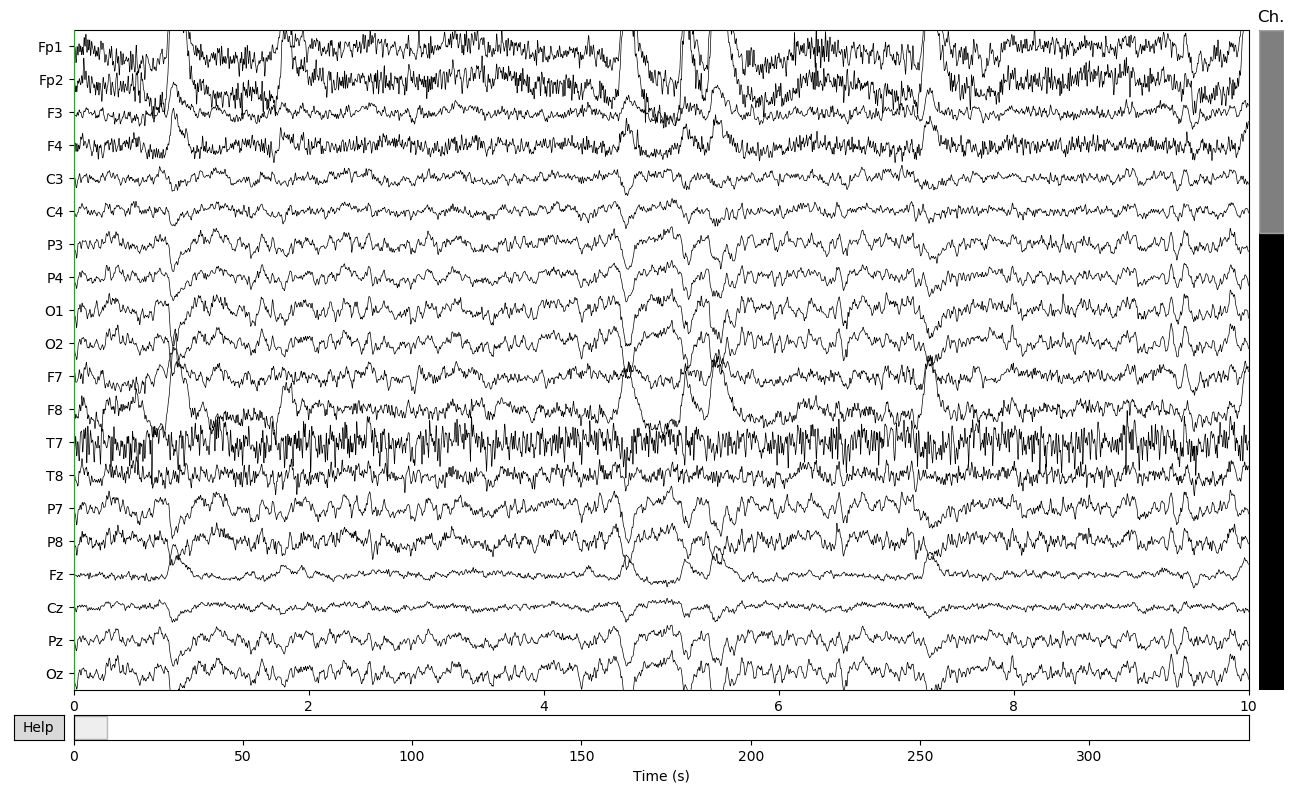

In [4]:
%matplotlib qt5
raw.plot()

DEBUG:matplotlib.backends:backend Qt5Agg version 5.9.2
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


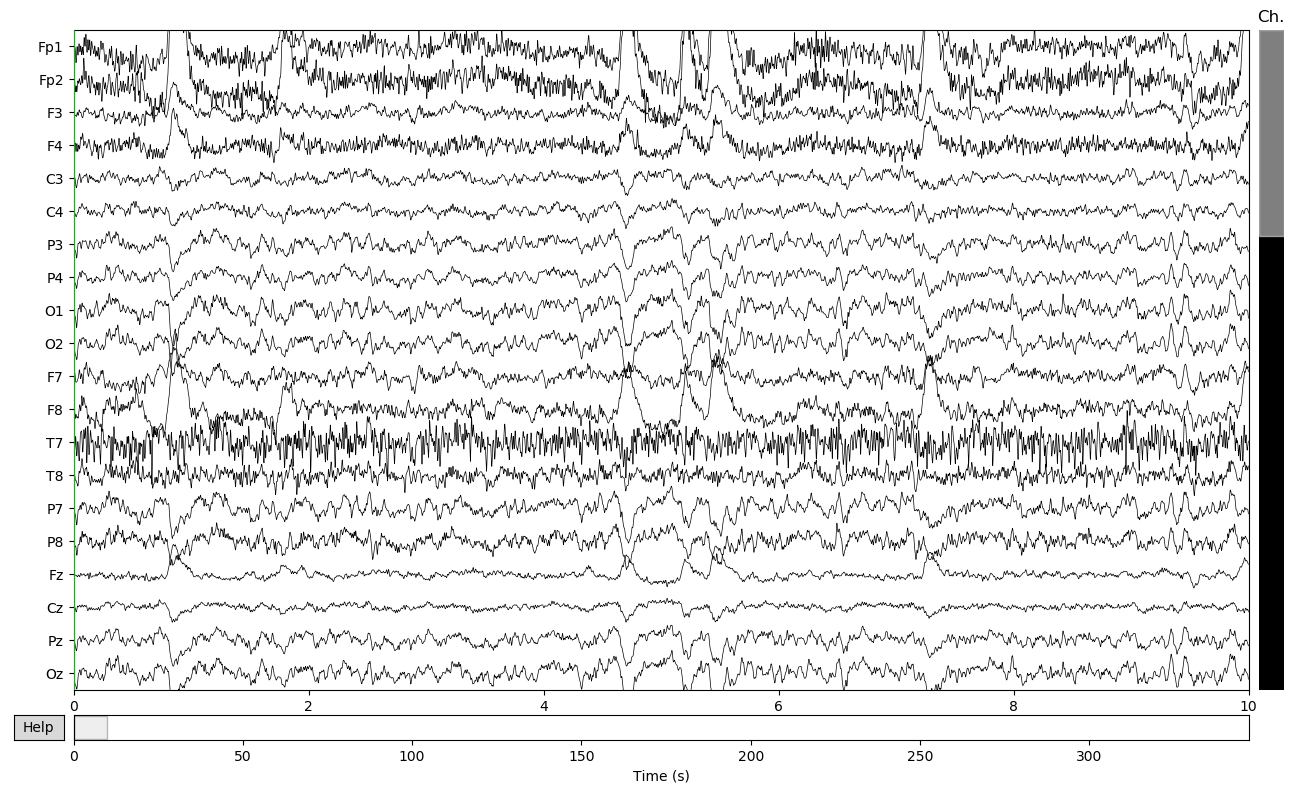

In [20]:
%matplotlib qt5
raw.plot()

## Done!


In [42]:
raw

<RawArray  |  None, n_channels x n_times : 64 x 347001 (347.0 sec), ~169.6 MB, data loaded>

In [43]:
newraw=select_part_from_mne_dataset(raw, markers=[83, 85])

using markers
2427 events found
Event IDs: [  1   2   3   4   5   6   7   8  11  12  13  14  15  21  23  24  26  30
  31  40  41  42  43  44  45  46  51  52  53  54  55  56  60  80  81  82
  83  84  85  86 131 132 133 134 135 136 140 201]
using boundaries
[[ 9.05750084e-06  7.86074373e-06  7.12315268e-06 ...  1.88333659e-05
   2.07849688e-05  2.14241893e-05]
 [-1.04612306e-05 -1.28250756e-05 -1.39741461e-05 ...  7.30551010e-06
   7.58544167e-06  8.17010222e-06]
 [ 3.78298353e-06  3.65887010e-06  3.40631337e-06 ...  7.90164465e-06
   7.41402314e-06  6.70841091e-06]
 ...
 [-3.13656727e-06 -4.07282725e-06 -4.82783747e-06 ...  9.17732111e-06
   9.75808891e-06  1.06762499e-05]
 [-5.46029414e-06 -5.44946391e-06 -5.52735680e-06 ... -4.30651429e-07
  -2.60215822e-07 -2.91649536e-07]
 [ 8.30000000e+01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Creating RawArray with float64 data, n_channels=64, n_times=38604
    Range : 0 ... 38603 =      0.000 ...  